In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from copy import deepcopy
from random import randint
import scipy as sp
from sklearn.metrics.pairwise import euclidean_distances
from scipy import sparse
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
import time
from sklearn.preprocessing import Normalizer
from sklearn.metrics import f1_score,accuracy_score,log_loss
from sklearn import metrics

In [0]:
from google.colab import files
import io
uploaded = files.upload()
X_train,y_train = load_svmlight_file("train")

Saving training to training (1)


In [0]:
def eucDist(x,y):
    '''
    measure euclidean distance
    '''
    diff = x-y
    #print(type(diff))
    return np.sqrt(diff.multiply(diff).sum(1))

def clusterDist_standard(data,centroid):
    '''
    Distance of a point from cluster
    '''
    cluster = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        cluster[i]=eucDist(data[i],centroid)
    return cluster

def clusterDist(data,centroid):
    '''
   Calculate the euclidean distance using sklearn implementation
    '''
    return euclidean_distances(data, centroid).flatten()

def reduceDim(data,components):
  '''
  Perform the LSA, this is done to speed up the model
  '''
  svd = TruncatedSVD(components)
  normalizer = Normalizer(copy=False)
  lsa = make_pipeline(svd, normalizer)
  return svd, sparse.csr_matrix(lsa.fit_transform(X_train))
  
def KMeanImproved(data,response,k,it=75,decomposer = None):
    '''
    Perform the k means
    '''
    cluster_point_new = {}
    cluster_point_old = {}
    first_pass = True
   
    n= data.shape[0] #number of samples
    centroid_old = np.zeros((k,data.shape[1]))# to store old centers
    centroid_new = data[list(randint(0,data.shape[0]) for i in range(k))] #create_centroids(data,k,centroid_new)
    clusters = np.zeros(n)
    dist = np.zeros((n,k))
    
    j =0
    while j<it:
        
        first_pass = False
        for i in range(k):
            dist[:,i] = clusterDist(data,centroid_new[i])  #create the distance matrix
        clusters = np.array(np.argmin(dist, axis = 1))     #get the cluster label
        cluster_point_old = deepcopy(cluster_point_new)
        
        for i in range(k):
            cluster_point_new[i] = list(np.argwhere(clusters == i).flatten())   #recluster
            centroid_new[i] = np.array(data[cluster_point_new[i]].mean(axis=0))  #normalize the cluster
        if (cluster_point_old == cluster_point_new):
          break
        j +=1
    cluster_label = build_cluster_label(cluster_point_new,response)   #create the labels for clusters
    
    centroid_new = decomposer.inverse_transform(centroid_new.toarray())  #undo the lsa
    return centroid_new,cluster_label,cluster_point_new 

def build_cluster_label(cluster_point_new,response):
    '''
  Assign labels to cluster based on average value of the cluster
    '''
    cluster_label = {}
    for index,value in cluster_point_new.items():
        #print(type(value))
        cluster_label[index] = round(np.sum(response[value])/len(response[value]))
    return cluster_label
    
def predict(data,centroids,clusters,k,encoding_dict):
    '''
    Perform the prediction
    '''
    pred_label = []
    dist = np.zeros((data.shape[0],k))
    for i in range(k):
      dist[:,i] = clusterDist_standard(data,sparse.csr_matrix(centroids[i]))
    pred_label =[clusters[x] for x in list(np.argmin(dist,axis=1))]
    return pred_label

def sse(data,clusters,centroid_new,k):
    '''
    Estimate the within cluster sum of squares
    '''
    total_error = 0
    for i in range(k):
        total_error+=np.sum(clusterDist_standard(data[clusters[i]],sparse.csr_matrix(centroid_new[i])))
    return total_error

Determining the best k value for KMeans implementation

In [0]:
import time
scores = {}
times = {}
#running our algo for k value between 15 to 25 clusters
decomposer, data = reduceDim(X_train,3000)
for k in range(18,23):
    #print(k)
    centroids,cluster_label,clusters = KMeanImproved(data,y_train,k,decomposer=decomposer)
    scores[k] = sse(X_train,clusters,centroids,k)
    times[k]= (end - start)
    #print((end - start))

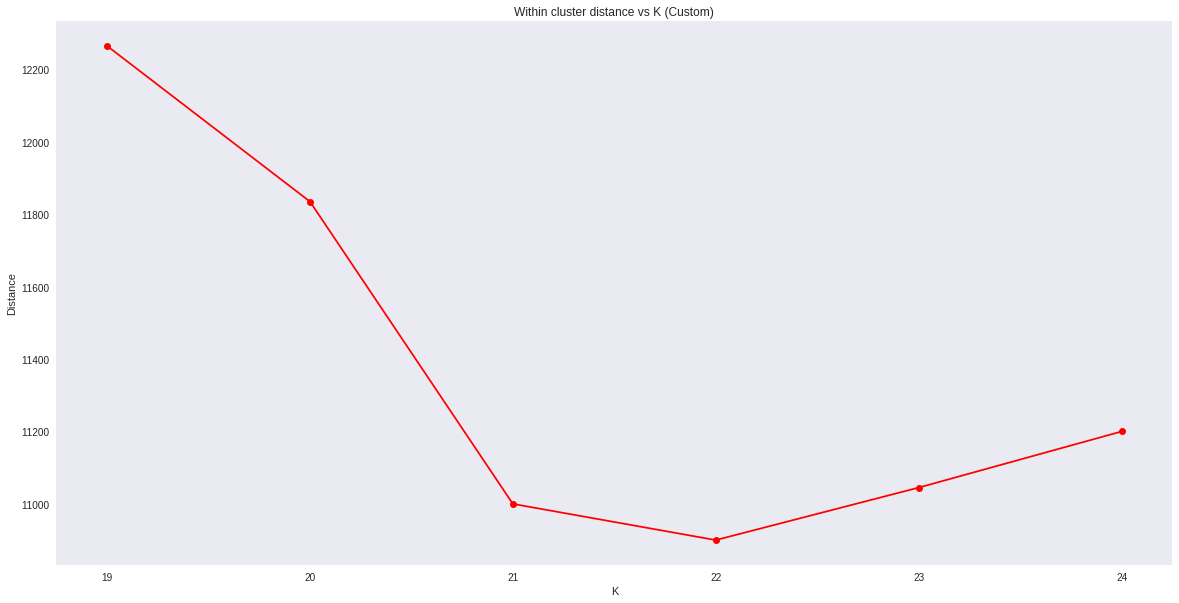

In [0]:
#plot the results 
plt.figure(figsize=(20, 10))
plt.plot(scores.keys(),scores.values(),'-ro')
plt.grid()
plt.title("Within cluster distance vs K (Custom)")
plt.xlabel("K")
plt.xticks(list(scores.keys()))
plt.ylabel("Distance")
plt.show()

We can see that optimal number of clusters is at 21, hence we will use it to create our KMean

Evaluating the performance on the test set

In [0]:
from google.colab import files
import io
uploaded = files.upload()
X_test,y_test = load_svmlight_file("test")

Saving testing to testing (1)


In [0]:
start = time.time()
decomposer, data = reduceDim(X_train,3000)
centroids,cluster_label,clusters = KMeanImproved(data,y_train,21,decomposer=decomposer)
end = time.time()
print("Fitting time",(end-start))
y_pred = predict(X_test,centroids,cluster_label,k=21,encoding_dict=None)

Fitting time 205.575845651


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       397
         2.0       0.00      0.00      0.00       394
         3.0       0.00      0.00      0.00       398
         4.0       0.00      0.00      0.00       398
         5.0       0.00      0.00      0.00       396
         6.0       0.00      0.00      0.00       394
         7.0       0.00      0.00      0.00       364
         8.0       0.01      0.01      0.01       385
         9.0       0.02      0.00      0.01       310
        10.0       0.36      0.21      0.26       396
        11.0       0.00      0.00      0.00       389
        12.0       0.05      1.00      0.10       376
        13.0       0.00      0.00      0.00       251
        14.0       0.00      0.00      0.00       390
        15.0       0.00      0.00      0.00       393
        16.0       0.00      0.00      0.00       399
        17.0       0.00      0.00      0.00       392
        18.0       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Using sklearn's implementation and evaluating the fitting time

In [0]:
inertias = {}
for i in range(19, 24):
    kMean = KMeans(n_clusters=i)
    kMean.fit(X_train, y_train)
    inertias[i] = kMean.inertia_

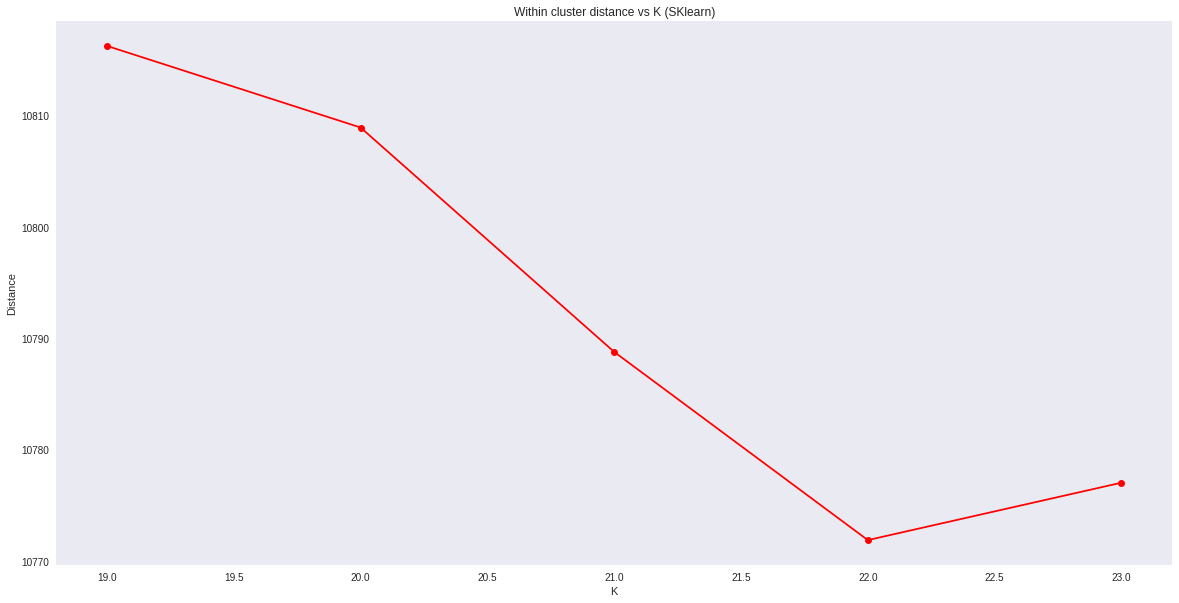

In [0]:
plt.figure(figsize=(20, 10))
plt.plot(inertias.keys(),inertias.values(),'-ro')
plt.grid()
plt.title("Within cluster distance vs K (SKlearn)")
plt.xlabel("K")
plt.ylabel("Distance")
plt.show()

In [0]:
start = time.time()
kmeans = KMeans(n_clusters=22, n_init = 1)
kmeans.fit(X_train, y_train)
end = time.time()
print("Fitting time",(end-start))
y_pred = kmeans.fit_predict(X_test)

Fitting time 32.48821544647217


sklearn performs a better fitting model in relatively less time. 

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00       397
         2.0       0.05      0.01      0.02       394
         3.0       0.00      0.00      0.00       398
         4.0       0.17      0.04      0.06       398
         5.0       0.00      0.00      0.00       396
         6.0       0.04      0.25      0.07       394
         7.0       0.00      0.00      0.00       364
         8.0       0.00      0.00      0.00       385
         9.0       0.98      0.20      0.33       310
        10.0       0.08      0.16      0.11       396
        11.0       0.01      0.01      0.01       389
        12.0       0.00      0.00      0.00       376
        13.0       0.00      0.00      0.00       251
        14.0       0.03      0.01      0.01       390
        15.0       0.00      0.00      0.00       393
        16.0       0.03      0.02      0.02       399
        17.0       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Our code performs well with less number of feature but sklearn's model works well and has better f score with all the dimensions intact 